In [1]:
import ROOT as r
import numpy as np
from array import array
import root_numpy as rn
import matplotlib.pyplot as plt
import pickle
import math
import os

from tools.data_processing import *
from tools.kinematics_fix import *
from tools.preselector import *


/home/hep/davide/miniconda3/envs/root_env/lib/ROOT.py:301: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return _orig_ihook( name, *args, **kwds )


In [2]:
l_index = 1
mother_index = 1
data_index = 1
apply_phi_mass_cut = True
n_cats=6
data_type = ['MC','data']
mother_ID=['Dplus','Ds']
l_flv = ['e','mu']
PATH='/disk/lhcb_data/davide/Rphipi_new/'

save_path_presel_data=PATH+data_type[data_index]+'/'+l_flv[l_index]+'_tuples/presel/'
save_path_trigged_data=PATH+data_type[data_index]+'/'+l_flv[l_index]+'_tuples/trigged/'
save_path_trigCats_data=save_path_trigged_data+'trigCats/'
save_path_BDT_for_data=PATH+data_type[data_index]+'/'+l_flv[l_index]+'_tuples/for_BDT_training/'

In [3]:
#retrieve files

def find_file_path(l_index=l_index, mother_index=mother_index): 
    return "/disk/lhcb_data/davide/Rphipi/data/"+mother_ID[mother_index]+"_phipi_"+l_flv[l_index]+l_flv[l_index]+"/"+mother_ID[mother_index]+"_phipi_"+l_flv[l_index]+l_flv[l_index]+".root"

data = r.TFile(find_file_path(l_index=l_index, mother_index=mother_index))
tree_name_Ds = mother_ID[mother_index]+'_OfflineTree/DecayTree'
t_data = data.Get(tree_name_Ds)

# Converting tuples to dictionary

In [4]:
#Switch on only the branches that you need
data_tuple_dict = {}

t_data.SetBranchStatus("*",0)

for branch in return_branches(data_index=data_index, mother_index=mother_index, l_index=l_index):
    if branch!='cos_thetal':
        t_data.SetBranchStatus(branch, 1)

branches_needed=return_branches(data_index=data_index, mother_index=mother_index, l_index=l_index)
for branch in branches_needed:
    if branch!='cos_thetal':
        data_tuple_dict[branch] = rn.root2array(
            
            filenames=find_file_path(l_index, mother_index=mother_index),
            treename = tree_name_Ds,
            branches = branch,
            start=0,
            stop=t_data.GetEntries(),
        )
    
data_tuple_dict = fix_mass_vector(data_tuple_dict, 'Ds_ConsD_M')

# Phi Mass Cut 

In [5]:
#for plot purposes
#data_tuple_dict_phi_cut=data_tuple_dict

if apply_phi_mass_cut:
    
    if l_flv[l_index]=='mu':
        lower_phi_mass = 990
        upper_phi_mass = 1050
        
    if l_flv[l_index]=='e':
        lower_phi_mass = 870
        upper_phi_mass = 1110
        
    data_tuple_dict =filter_tuple_mass_cut(locals(), data_tuple_dict, l_index, 
                                           'phi_M', lower_bound=lower_phi_mass, upper_bound=upper_phi_mass, 
                                           cut_kind='inside', include_costhetal = False)
    
##nice plot
#for i in range(20):
#    
#    upper_cut=np.arange(800+5*i,1100-5*i).max()
#    lower_cut=np.arange(800+5*i,1100-5*i).min()
#    plt.clf()
#    data_tuple_dict_phi_cut=filter_tuple_mass_cut(globals(), data_tuple_dict_phi_cut, l_index, 'phi_M', lower_bound=lower_cut, upper_bound=upper_cut)
#    plt.hist(data_tuple_dict_phi_cut['Ds_ConsD_M'],bins=40);
#    plt.savefig('plot_{0}.png'.format(i))

# PID Cut 

In [6]:
if l_flv[l_index]=='mu':
    lPID_cut = 0.4
    piPID_cut = 0.6
    
    
if l_flv[l_index]=='e':
    lPID_cut = 0.2
    piPID_cut = 0.6
        
data_tuple_dict_eplusPID =filter_tuple_cond(locals(), data_tuple_dict, l_index, l_flv[l_index]+"_plus_MC15TuneV1_ProbNN"+l_flv[l_index], cmp_gte, lPID_cut, include_costhetal=False)
data_tuple_dict_eminusPID =filter_tuple_cond(locals(), data_tuple_dict_eplusPID, l_index, l_flv[l_index]+"_minus_MC15TuneV1_ProbNN"+l_flv[l_index], cmp_gte, lPID_cut, include_costhetal=False)
data_tuple_dict_presel =filter_tuple_cond(locals(), data_tuple_dict_eminusPID, l_index, 'pi_MC15TuneV1_ProbNNpi', cmp_gte, piPID_cut, include_costhetal=False)


# Add cos_thetal branch & save preselection

In [7]:
costheta_Ds=get_costheta_list(data_tuple_dict_presel, l_index=l_index, mother_index=mother_index)
data_tuple_dict_presel["cos_thetal"]=costheta_Ds

save_tuples(locals(), data_tuple_dict_presel, l_index, save_path_presel_data, file_format='pickle')
save_tuples(locals(), data_tuple_dict_presel, l_index, save_path_presel_data, file_format='root')


# Get Hlt cuts 

In [9]:
data_tuple_dict_presel_Hlt1 = filter_tuple_cond(locals(), data_tuple_dict_presel, l_index, 'Ds_Hlt1TrackMVADecision_TOS', cmp_eq, True)

data_tuple_dict_presel_Hlt2 = filter_tuple_cond(locals(), data_tuple_dict_presel, l_index, "Ds_Hlt2RareCharmD2Pi"+l_flv[l_index].capitalize()+l_flv[l_index].capitalize()+"OSDecision_TOS",cmp_eq, True)

data_tuple_dict_presel_FullHlt = filter_tuple_cond(locals(), data_tuple_dict_presel_Hlt1, l_index, "Ds_Hlt2RareCharmD2Pi"+l_flv[l_index].capitalize()+l_flv[l_index].capitalize()+"OSDecision_TOS",cmp_eq, True)

save_tuples(locals(), data_tuple_dict_presel_Hlt1, l_index, save_path_trigged_data, file_format='pickle')
save_tuples(locals(), data_tuple_dict_presel_Hlt1, l_index, save_path_trigged_data, file_format='root')

save_tuples(locals(), data_tuple_dict_presel_Hlt2, l_index, save_path_trigged_data, file_format='pickle')
save_tuples(locals(), data_tuple_dict_presel_Hlt2, l_index, save_path_trigged_data, file_format='root')

save_tuples(locals(), data_tuple_dict_presel_FullHlt, l_index, save_path_trigged_data, file_format='pickle')
save_tuples(locals(), data_tuple_dict_presel_FullHlt, l_index, save_path_trigged_data, file_format='root')


Hlt1
Overwriting pickle file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/trigged/Ds_phipi_mumu_Hlt1.pickle
Hlt1
Saving root file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/trigged/Ds_phipi_mumu_Hlt1.root
Hlt2
Overwriting pickle file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/trigged/Ds_phipi_mumu_Hlt2.pickle
Hlt2
Saving root file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/trigged/Ds_phipi_mumu_Hlt2.root
FullHlt
Overwriting pickle file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/trigged/Ds_phipi_mumu_FullHlt.pickle
FullHlt
Saving root file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/trigged/Ds_phipi_mumu_FullHlt.root


# Split in trigger categories

    if trig_cat == 0:
        #Exclusive L0_Lepton_TOS 
        
    if trig_cat == 1:
        #Exclusive L0_Global_TIS
        
    if trig_cat == 2:
        #L0_Lepton_TOS and L0_Global_TIS
        
    if trig_cat == 3:
        #Either L0_Lepton_TOS or L0_Global_TIS
        
    if trig_cat == 4:
        #TOS and TOSandTIS

    if trig_cat == 5:
        #TIS and TOSandTIS

        
      

In [10]:
data_tuple_dict_presel_trigCats = {}

for i in range(n_cats):
    
    data_tuple_dict_presel_trigCats[i] = filter_tuple_L0TrigCat(locals(), data_tuple_dict_presel_FullHlt, l_index, trig_cat=i)
    
n_0=data_tuple_dict_presel_trigCats[0]['Ds_ConsD_M'].shape[0]
n_1=data_tuple_dict_presel_trigCats[1]['Ds_ConsD_M'].shape[0]
n_2=data_tuple_dict_presel_trigCats[2]['Ds_ConsD_M'].shape[0]
n_3=data_tuple_dict_presel_trigCats[3]['Ds_ConsD_M'].shape[0]
n_4=data_tuple_dict_presel_trigCats[4]['Ds_ConsD_M'].shape[0]
n_5=data_tuple_dict_presel_trigCats[5]['Ds_ConsD_M'].shape[0]

sanity=np.array_equal([n_0+n_2+n_1==n_3,n_0+n_5==n_3,n_4+n_1==n_3],[True,True,True])

if sanity:
    print('The counts are coming back')
    
    save_tuples(locals(), data_tuple_dict_presel_trigCats, l_index, save_path_trigCats_data, file_format='pickle')
    save_tuples(locals(), data_tuple_dict_presel_trigCats, l_index, save_path_trigCats_data, file_format='root')

The counts are coming back
Overwriting pickle file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/trigged/trigCats/0/Ds_phipi_mumu_trigCat0.pickle
Overwriting pickle file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/trigged/trigCats/1/Ds_phipi_mumu_trigCat1.pickle
Overwriting pickle file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/trigged/trigCats/2/Ds_phipi_mumu_trigCat2.pickle
Overwriting pickle file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/trigged/trigCats/3/Ds_phipi_mumu_trigCat3.pickle
Overwriting pickle file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/trigged/trigCats/4/Ds_phipi_mumu_trigCat4.pickle
Overwriting pickle file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/trigged/trigCats/5/Ds_phipi_mumu_trigCat5.pickle
Saving root file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/trigged/trigCats/0/Ds_phipi_mumu_trigCat0.root
Saving root file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/trigged/trigCats/1/Ds_phipi_mumu_trigCat1.root

# Prepare Bkg Sets for BDT

In [11]:
if l_flv[l_index]=='mu':
    
    lower_Dplus_mass_data=1830
    upper_Dplus_mass_data=1910
    
    lower_Ds_mass_data=1930
    upper_Ds_mass_data=2010
    
    
if l_flv[l_index]=='e':
    
    lower_Dplus_mass_data=1810
    upper_Dplus_mass_data=1920

    lower_Ds_mass_data=1920
    upper_Ds_mass_data=2020
    
data_Ds_tuple_dict_bkg_1 = filter_tuple_mass_cut(locals(), data_tuple_dict_presel_FullHlt, l_index, 'Ds_ConsD_M', lower_bound=lower_Dplus_mass_data, upper_bound=upper_Dplus_mass_data, cut_kind='outside')
data_Ds_tuple_dict_bkg_for_BDT = filter_tuple_mass_cut(locals(), data_Ds_tuple_dict_bkg_1, l_index, 'Ds_ConsD_M', lower_bound=lower_Ds_mass_data, upper_bound=upper_Ds_mass_data, cut_kind='outside')
    
save_tuples(locals(), data_Ds_tuple_dict_bkg_for_BDT, l_index, save_path_BDT_for_data, file_format='pickle')
save_tuples(locals(), data_Ds_tuple_dict_bkg_for_BDT, l_index, save_path_BDT_for_data, file_format='root')    


for_BDT
Saving pickle file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/for_BDT/Ds_phipi_mumu_for_BDT.pickle
for_BDT
Saving root file at/disk/lhcb_data/davide/Rphipi_new/data/mu_tuples/for_BDT/Ds_phipi_mumu_for_BDT.root


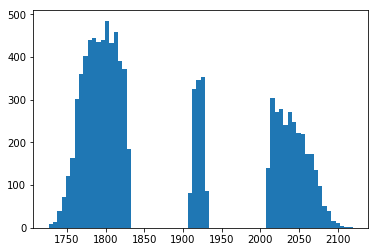

In [12]:
plt.hist(data_Ds_tuple_dict_bkg_for_BDT['Ds_ConsD_M'], bins=70);

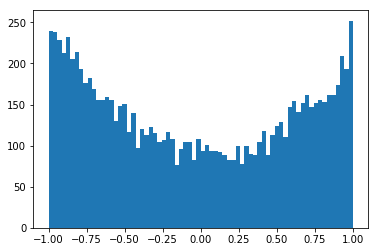

In [13]:
plt.hist(data_Ds_tuple_dict_bkg_for_BDT['cos_thetal'], bins=70);